Loading the mnist dataset from keras datasets and then filtering it to contain only the digit '5' data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from keras.datasets import mnist

(X_train, y_train), (x_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
train_filter = np.where((y_train == 5 ))
X_train5, y_train5 = X_train[train_filter], y_train[train_filter]
mnist5DatasetValues = pd.DataFrame(data = X_train5)
mnist5DatasetLabels = pd.DataFrame(data = y_train5)
print(mnist5DatasetValues.shape)
print(mnist5DatasetLabels.shape)

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
(5421, 784)
(5421, 1)


Computing and displaying the mean digit image of number 5.
For computing the principal component 1 and 2 first we preprocess the input data using the Standard Scaler method. This is beneficial as the PCA is more accurate with normalised data. Then we computer the covariance matrix by taking the multiplication of the data and its transpose. Using the covariance matrix we can then calculate the eigen values and eigen vectors. After getting the eigenVectors and values we then sort them in a descending order and take the first two i.e. the hightest two corresponding to the principal component 1 and 2. Corresponding to the highest eigenValues, the vectors are selected and and multiplied with the data to get the new coordinates. These new coordinates form out principal component 1 and 2.

(784,)


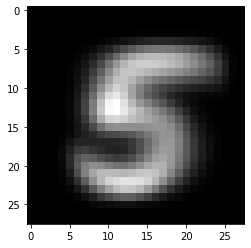

   1st Principal Component  2nd Principal Component
0                -0.246809                 7.381043
1                 9.677048                -9.227580
2                 8.299623                -4.171733
3                 8.948474                 0.834620
4                 9.598707                -9.952470
5                 3.888056                 0.047207
6                 2.477526                 0.347956
7                -4.308302                 1.593020
8                10.514681                -8.052405
9                 9.660829                -8.780168


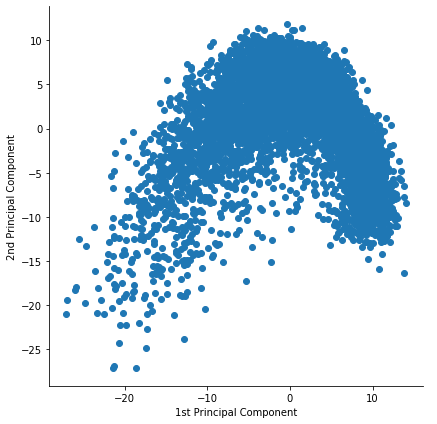

In [5]:
#1. Computing the mean image and principal components for a set of images

#mean image
mean_Image = mnist5DatasetValues.mean(axis=0)
print(mean_Image.shape)
meanImage = np.array(mean_Image, dtype='float')
meanImage = meanImage.reshape((28, 28))
plt.imshow(meanImage, cmap='gray')
plt.show()

from sklearn.preprocessing import StandardScaler
mnistDataset = StandardScaler().fit_transform(mnist5DatasetValues)

covar_matrix = np.matmul(mnistDataset.T , mnistDataset)
from scipy.linalg import eigh
eigenValues, eigenVectors = eigh(covar_matrix)
idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
principal2vectors = eigenVectors[:, 0:2].T

import matplotlib.pyplot as plt
new_coordinates = np.matmul(principal2vectors, mnistDataset.T).T
dataframe = pd.DataFrame(data=new_coordinates, columns=('1st Principal Component', '2nd Principal Component'))
print(dataframe.head(10))

import seaborn as sn
sn.FacetGrid(dataframe, height=6).map(plt.scatter, '1st Principal Component', '2nd Principal Component').add_legend()
plt.show()


For PCA reconstruction, we first project the mean image using the mentioned eigenVectors i.e. principal components 10 and 50. Once the image is projected, we reconstruct the image using the same eigenVectors and display the image. As you can see, the mean image, and the reconstructed image using 10 and 50 components. The image reconstructed using only 10 principal components is blurred and the image with 50 components is slightly clearer than that of the 10 components but still comparetively blurred as the mean image.

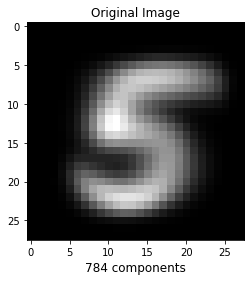

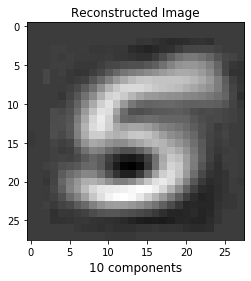

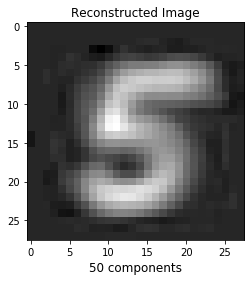

In [6]:
#2. Computer and display the recontructions of the mean image with p = 10 and 50
from sklearn.decomposition import PCA
mnist5ArrayValues = np.asarray(mnist5DatasetValues)

plt.imshow(meanImage.reshape(28,28), cmap='gray', interpolation='nearest')
plt.xlabel('784 components', fontsize = 12)
plt.title('Original Image', fontsize = 12);
plt.show()

def projectImage(image, eigenVectors, no_components):
  newEigenVectors = eigenVectors[:, :no_components]
  return image.dot(newEigenVectors)

def reconstructImage(projectedImage, eigenVectors, no_components):
  newEigenVectors = eigenVectors[:,:no_components]
  return projectedImage.dot(newEigenVectors.T)

def displayReconstructedImage(n_components):
  projectedPCAImages = projectImage(mean_Image, eigenVectors, n_components)
  reconstructedPCAImages = reconstructImage(projectedPCAImages, eigenVectors, n_components)
  plt.imshow(reconstructedPCAImages.reshape(28,28), cmap='gray', interpolation='nearest')
  label = "{} components".format(n_components)
  plt.xlabel(label, fontsize = 12)
  plt.title('Reconstructed Image', fontsize = 12)
  plt.show()

#10 Components
displayReconstructedImage(10)

#50 Components
displayReconstructedImage(50)

First we need to define the test image to be used for the SSD snd DFFS heatmap. The generate combined image method used the first 100 digits from the mnist dataset and creates a 10 into 10 combined image of the mnist digits. Using this image as a base, a sliding window is implemented for getting the window and comparing it with the mean image, for this we have define a method generate window which creates a sliding window of size 28*28 to be used to calculate the SSD and DFFS. Using the formula for SSD and DFFS (using 2 principal eigne vecotrs) we get the values of SSD an DFFS and plot it as a heat map image.

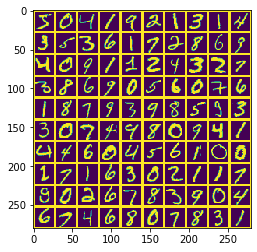

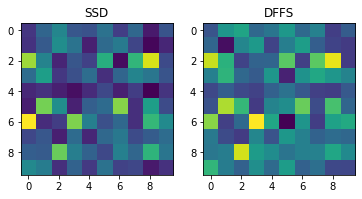

In [38]:
#3. Computing DFFS and SSD heat maps
import matplotlib.image as mpimg
import numpy as np
import cv2

def ssd(image, window):
  SSD = 0
  SSD = np.sum(pow(window-image, 2))
  return SSD

def dffs(image, window, SSD):
  difference = (window-image).flatten()
  alpha1 = np.dot(difference, eigenVectors[:, 0])
  alpha2 = np.dot(difference, eigenVectors[:, 1])
  DIFS = (alpha1**2 + alpha2**2)
  DFFS = SSD - DIFS
  return DFFS  

#code to generate the test combined image for SSD and DFFS
def generateCombinedImage():
  testImages = X_train[0:101]
  temp2Image = np.array([])
  temp1Image = testImages[0].reshape(28,28)
  for i in range (1, 101):
    if i%10 == 0:
      if temp2Image.size == 0:
        temp2Image = np.copy(temp1Image)
      else:
        temp2Image = cv2.vconcat([temp2Image, temp1Image])
      temp1Image = np.array([])
    if temp1Image.size == 0:
      temp1Image = testImages[i].reshape(28,28)
    else:
      temp1Image = cv2.hconcat([temp1Image, testImages[i].reshape(28,28)])
  finalTestImage = temp2Image

def windowGeneration(image):
  SSD = np.array([])
  DFFS = np.array([])
  tmp = finalTestImage
  stepSize = 28
  (w_width, w_height) = (28, 28)
  for x in range(0, finalTestImage.shape[1], stepSize):
    for y in range(0, finalTestImage.shape[0], stepSize):
      window = finalTestImage[x:x + w_width, y:y + w_height]
      ssdValue = ssd(image, window)
      dffsValue = dffs(image, window, ssdValue)
      SSD = np.append(SSD, ssdValue)
      DFFS = np.append(DFFS, dffsValue)
      cv2.rectangle(tmp, (x, y), (x + w_width, y + w_height), (255, 0, 0), 2)
      plt.imshow(np.array(tmp).astype('uint8'))
  plt.show()
  SSD = SSD.reshape(10,10)
  plt.subplot(1,2,1)
  plt.imshow(SSD)
  plt.title('SSD', fontsize = 12)
  DFFS = DFFS.reshape(10,10)
  plt.subplot(1,2,2)
  plt.imshow(DFFS)
  plt.title('DFFS', fontsize = 12)
  plt.show()

generateCombinedImage()
windowGeneration(meanImage)

Given below we are comparing the SSD and DFFS values of the meanImage and the first digit in the mnist database. As we can see in Case 1 when we use the meanImage the SSD and DFFS is slightly similar with darks and brights in the same regions. However majority have a darker shade i.e. they were more similar. In Case 2, the exact image selected is black and all other images are on the ligher side which is more accurate, however the DFFS is not similar to that of the SSD in case 2. The DFFS gices wrong results in this case.

SSD and DFFS with the mean image


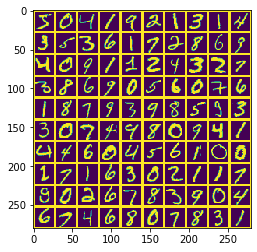

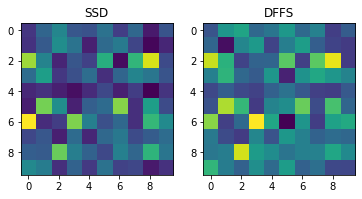

SSD and DFFS with an actual digit


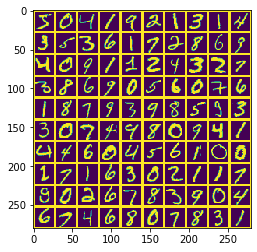

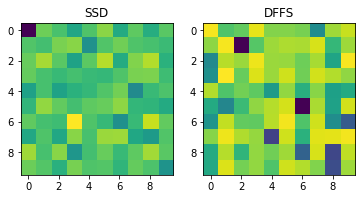

In [39]:
#4. Evaluation of SSD and DFFS

print('SSD and DFFS with the mean image')
image = windowGeneration(meanImage)

print('SSD and DFFS with an actual digit')
windowGeneration(testImages[0].reshape(28,28))